In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/Data/head_ct'

/content/drive/My Drive/Data/head_ct


In [3]:
%ls

head_ct/  labels.csv


In [7]:
from glob import glob
import os
import pandas as pd 
import cv2
import numpy as np

# Now we define the dimensions of our images.

img_width, img_height = 128, 128

files = sorted(glob('head_ct/*.png'))

labels = pd.read_csv('labels.csv')[' hemorrhage'].tolist()

images = np.empty((len(files), img_width, img_height))

for i, _file in enumerate(files):
    images[i, :, :] = cv2.resize(cv2.imread(_file, 0), (img_width, img_height))
    
print ('\033[1m' + 'Ready for next step!')

Ready for next step!


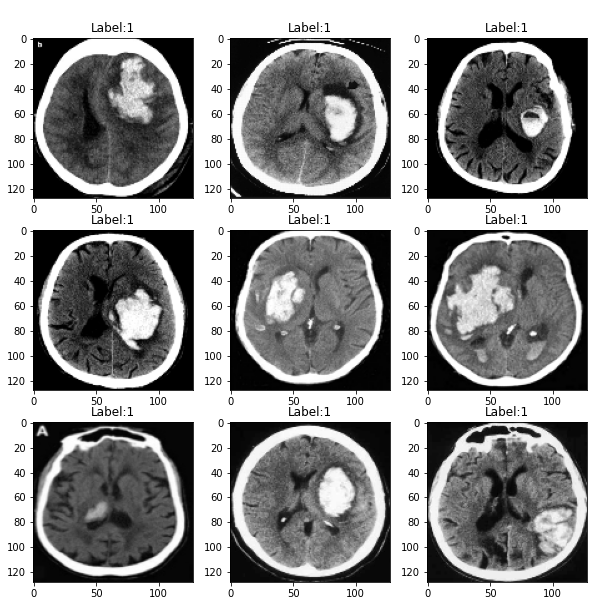

In [8]:
#Let's take a look at the images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i], cmap=plt.get_cmap('gray'))
    plt.title("\nLabel:{}".format(labels[i]))
# show the plot
plt.show()

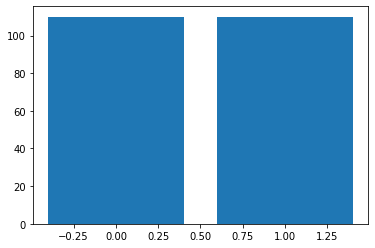

In [9]:
#Let's take a look at the proportion of normal and hemorrhage labels
dum = plt.bar(labels, 110)

In [10]:
#Now we split the dataset into train (80%), validation (10%) and test (10%) sets.
from sklearn.model_selection import train_test_split
import numpy as np

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=1)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=1)

print((len(train_images), len(val_images), len(test_images)))

(160, 20, 20)


In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K

input_shape = (img_width, img_height, 1)

SIIM_custom_model = None

SIIM_custom_model = Sequential()

#Below we have the first Convolutional Layer

SIIM_custom_model.add(Conv2D(32, (3, 3), input_shape=input_shape))
SIIM_custom_model.add(Activation('relu'))

#We then add a MaxPool layer, which will reduce the size of the output of the first conv layer in 75%.
#This is performed to avoid an exagerated increase in the number of parameters of the network.
#Don't worry if you do not understand in detail each one of these operations right now. Try to focus on the big picture.

SIIM_custom_model.add(MaxPooling2D(pool_size=(2, 2)))

#We will add more convolutional layers, followed by MaxPool layers

SIIM_custom_model.add(Conv2D(32, (3, 3)))
SIIM_custom_model.add(Activation('relu'))
SIIM_custom_model.add(MaxPooling2D(pool_size=(2, 2)))

SIIM_custom_model.add(Conv2D(64, (3, 3)))
SIIM_custom_model.add(Activation('relu'))
SIIM_custom_model.add(MaxPooling2D(pool_size=(2, 2)))

#Finally, we will add two dense layers, or 'Fully Connected Layers'.
#These layers are classical neural nets, without convolutions.

SIIM_custom_model.add(Flatten())
SIIM_custom_model.add(Dense(64))
SIIM_custom_model.add(Activation('relu'))

#Dropout is an overfitting reduction technique.

SIIM_custom_model.add(Dropout(0.5))

#Now, we will set the output o the network.
#The Dense function has the argument "1" because the net output is the hematoma x non-hematoma classification

SIIM_custom_model.add(Dense(1))

#The output is either 0 or 1 and this can be obtained with a sigmoid function.

SIIM_custom_model.add(Activation('sigmoid'))

#Let's compile the network.

SIIM_custom_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print ('\033[1m' + 'Ready for next step!')

Ready for next step!


In [13]:
from numpy.random import seed
seed(1337)
import tensorflow
tensorflow.random.set_seed(1337)

import warnings
warnings.filterwarnings('ignore')

nb_train_samples = len(train_images)
nb_validation_samples = len(val_images)
epochs = 100
batch_size = 10


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.0,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(
    train_images[..., np.newaxis],
    train_labels,
    batch_size=batch_size)

validation_generator = val_datagen.flow(
    val_images[..., np.newaxis],
    val_labels,
    batch_size=batch_size)

print ('\033[1m' + 'Ready for next step!')

Ready for next step!


In [14]:
history = SIIM_custom_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
16/16 [==============================] - 21s 257ms/step - loss: 0.7502 - accuracy: 0.4490 - val_loss: 0.7325 - val_accuracy: 0.3500
Epoch 2/100
16/16 [==============================] - 3s 196ms/step - loss: 0.6911 - accuracy: 0.6021 - val_loss: 0.6879 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 3s 196ms/step - loss: 0.6831 - accuracy: 0.5813 - val_loss: 0.6365 - val_accuracy: 0.7000
Epoch 4/100
16/16 [==============================] - 3s 196ms/step - loss: 0.6621 - accuracy: 0.5360 - val_loss: 0.6338 - val_accuracy: 0.7000
Epoch 5/100
16/16 [==============================] - 3s 195ms/step - loss: 0.6584 - accuracy: 0.6422 - val_loss: 0.5591 - val_accuracy: 0.8000
Epoch 6/100
16/16 [==============================] - 3s 195ms/step - loss: 0.5623 - accuracy: 0.6751 - val_loss: 0.6005 - val_accuracy: 0.7500
Epoch 7/100
16/16 [==============================] - 3s 196ms/step - loss: 0.5998 - accuracy: 0.6354 - val_loss: 0.6181 - val_accuracy: 0.750

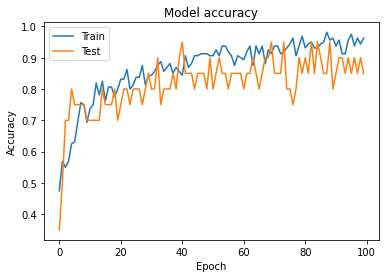

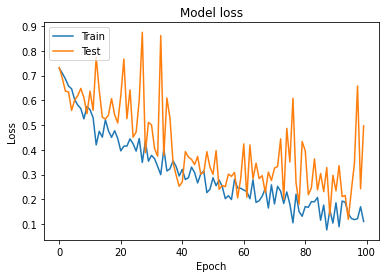

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
#Now we evaluate on the test set. Remember to make pixels between [0, 1] by dividing by 255.

print("Accuracy: " + str(SIIM_custom_model.evaluate(test_images[..., np.newaxis] / 255., np.array(test_labels))[1] * 100) + "%")

1/1 [==============================] - 1s 586ms/step - loss: 0.0945 - accuracy: 0.9500
Accuracy: 94.9999988079071%


In [ ]:
#https://www.kaggle.com/felipekitamura/head-ct-hemorrhage-kernel/data